# Klassifikation von Hunderassen mit einem Deep Learning Modell
Dieses Notebook nutzt zur Klassifizierung von Hunderassen ein Deep Learning Modells. Das gewählte Modell ist ein Convolutional Neural Network (CNN) mit zwei faltenden Layers, ein Mal mit 32 und ein Mal mit 64 Filtern. Anschließend kommen 2 Fully-Connected layers mit ein Mal 64 (Input aus dem Faltenden Layer) und ein Mal 5 (Anzahl der Klassen, also Hunderassem) Neuronen.
Es wird des Weiteren die L2 Regularisierung verwendet, sowie eine Datenaugmentierung (mit horizontalen und vertikalen Spiegelungen, sowie eine Drehung der Bilder) durchgeführt, um das Risiko des Overfittings zu begränzen.

In diesem Notebook wird das beschriebene Modell zunächst auf einem Datensatz kreuzvalidiert. Das Modell mit der besten Performance wird anschließend auf einem neuen Datensatz trainiert (Transfer Learning). Die Performance wird dann mit dem originalen Modell verglichen.

## Datensatz laden
Nun wird der Datensatz geladen, auf dem die Kreuzvalidierung des Modells durchgeführt werden soll. Es gibt insgesamt fünf Hunderassen: Standard Poodle, Mexican Hairless, Dingo, Dhole und African Hunting Dog. Diese Rassen wurden gewählt, weil sie vom Modell der Autoren des originalen Datensatzes diese Rassen am besten erkannt hat (s. Abbildung). Es gibt zu jeder Rasse 112 Trainingsbilder und 38 Testbilder, also insgesamt 560 Trainingsbilder und 190 Testbilder.

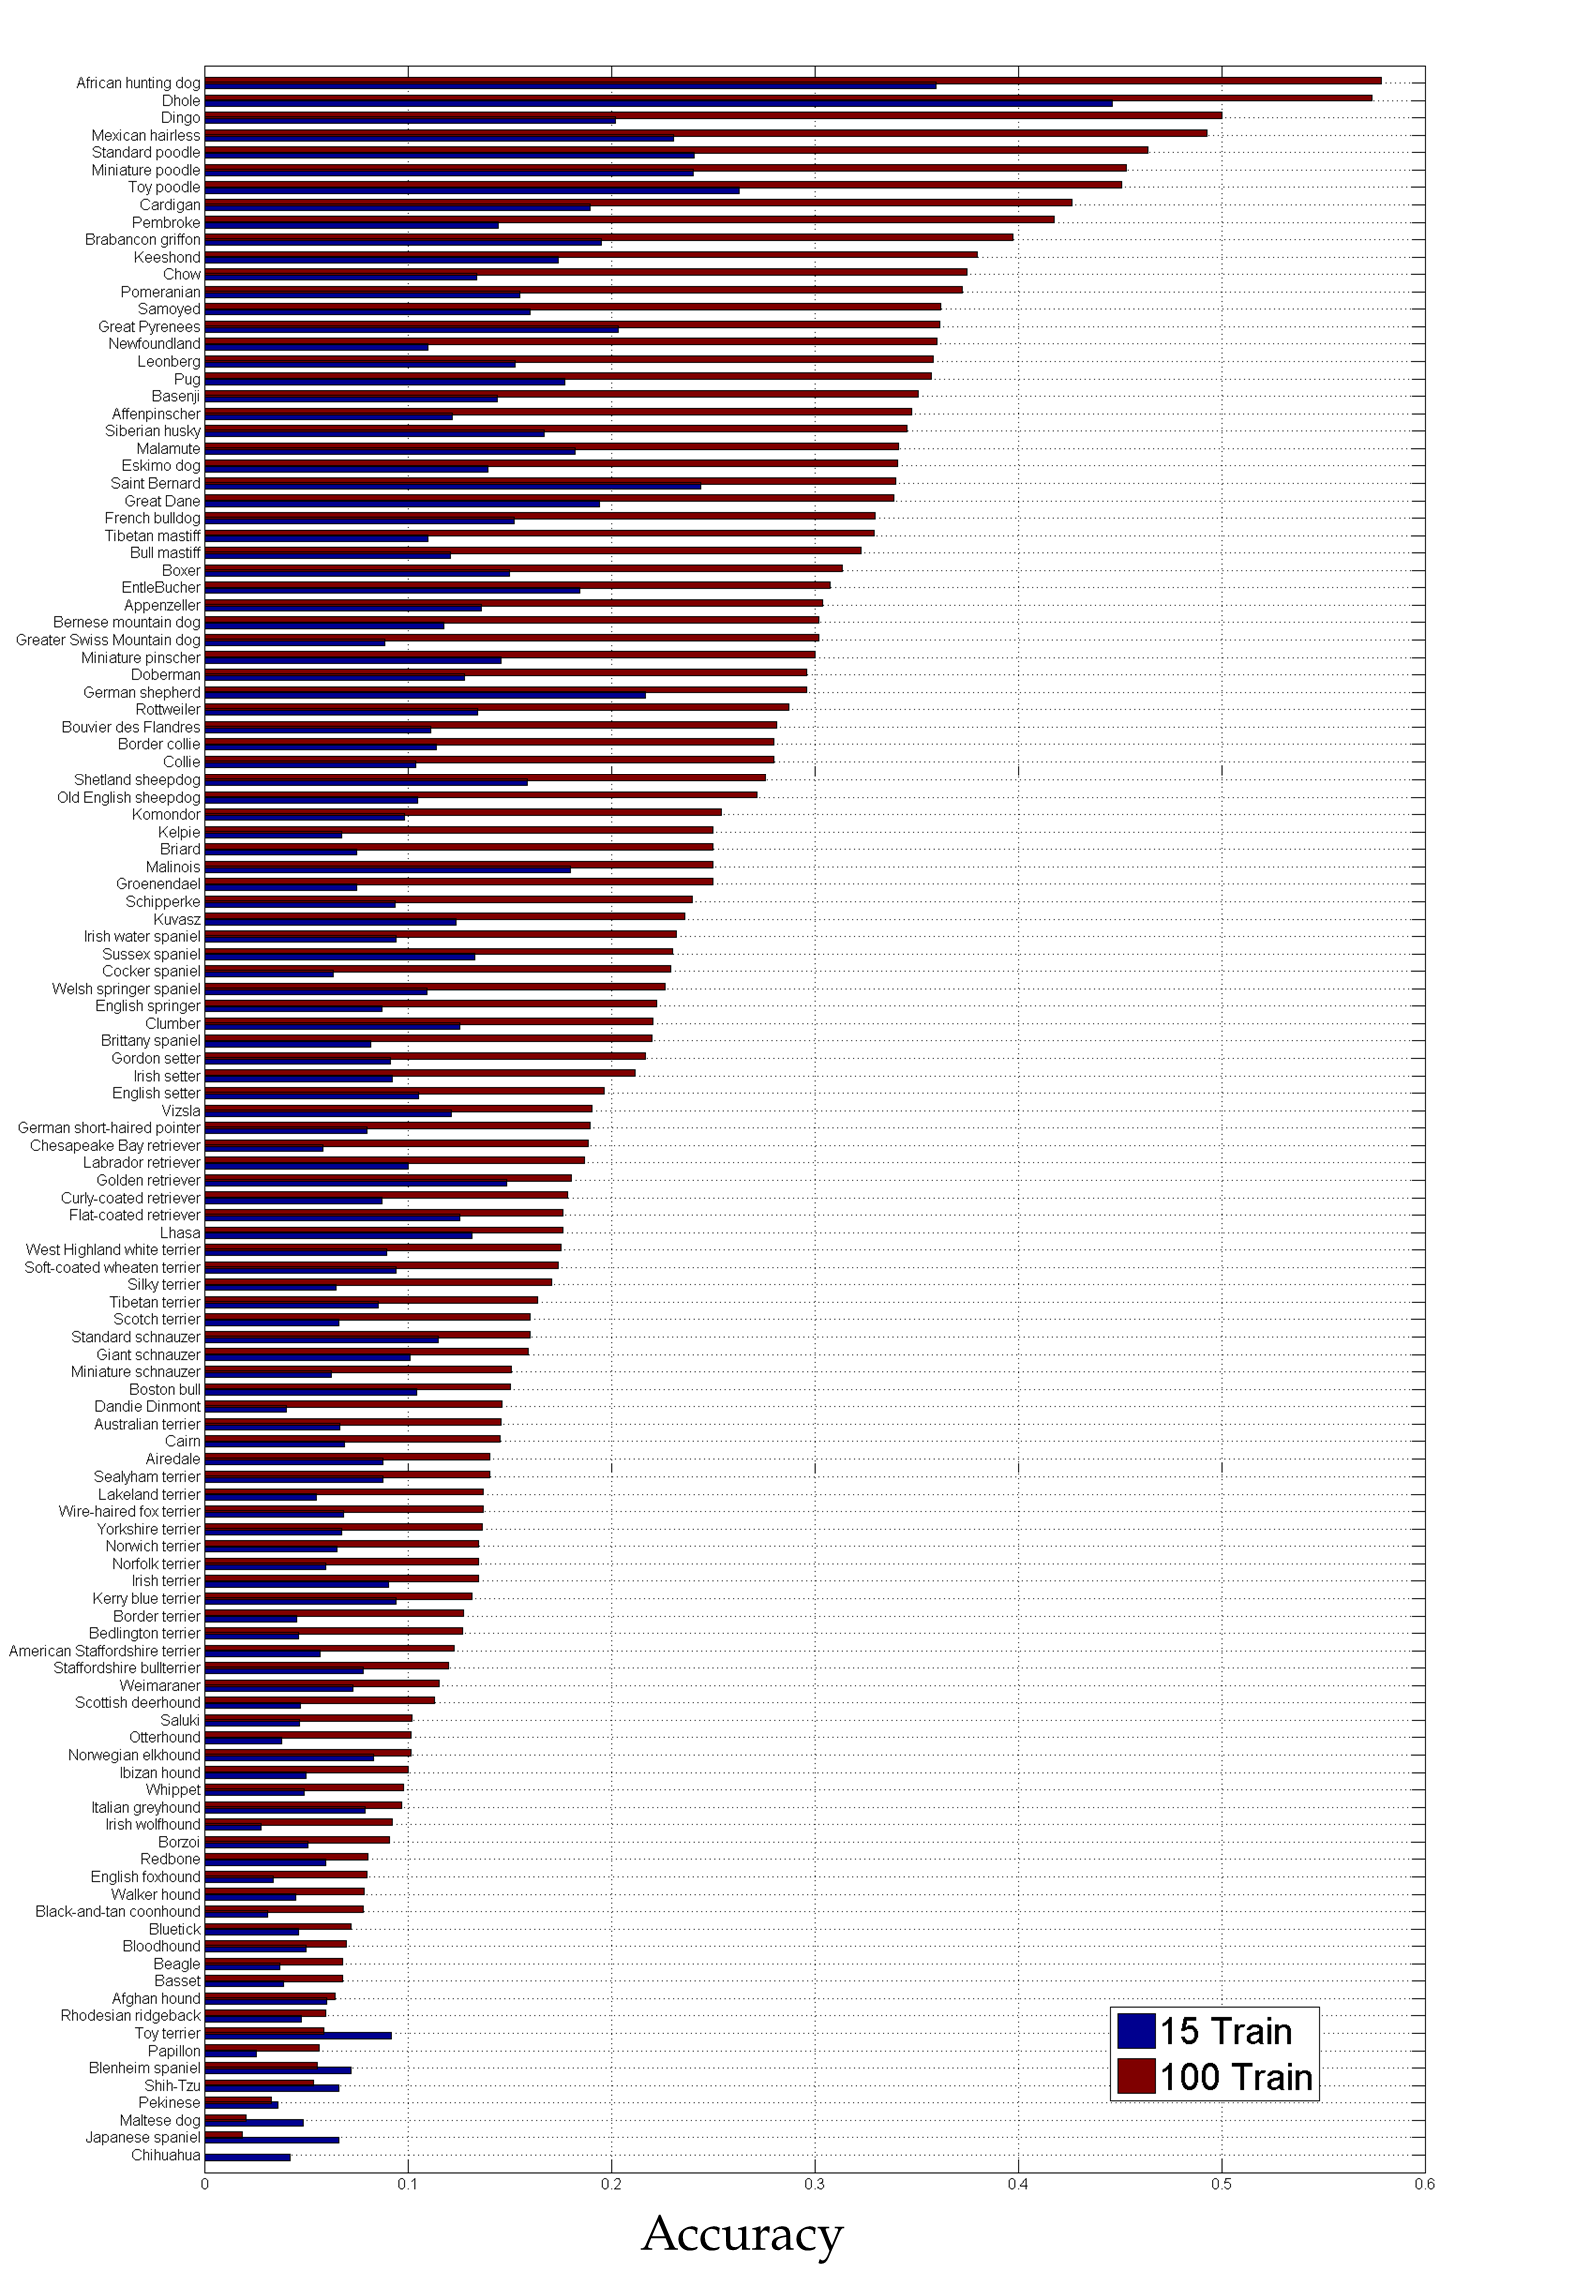

Anmerkung: vor der Ausführung von Funktionen in diesem Notebook sollte die Train/Test Split Funktion in der ersten Code Zelle des `svm.ipynb` Notebook ausgeführt werden.

In [ ]:
from helpers.dataloader import load_dataset
from numpy.random import seed
import tensorflow as tf

# Setting random seeds
seed(0)
tf.random.set_seed(0)

# Load Training and Testing data
x_train, y_train = load_dataset("./dataset/Train/Images")
x_test, y_test = load_dataset("./dataset/Test/Images")

## Modell mit K-Fold Kreuzvalidierung prüfen
Nun können wir das Modell, das in `./helpers/cnn.py` beschrieben ist, mit der K-Fold Kreuzvalidierung evaluieren. Diese ermöglicht eine bessere Evaluierung des Modells, da durch unterschiedliche Zusammensetzungen der Trainings- und Validierungsdatensätze das lucky/unlucky split Problem angegangen werden kann. Das Problem bezieht sich auf die Performance des Modells, die potentiell lediglich auf eine gute/schlechte Aufteilung der Trainings- bzw. Validierungsdaten zurückzuführen sein könnte. Hohe Performanceschwankungen bei unterschiedlichen Folds der Kreuzvalidierung deutet dann genau darauf hin - dass alleine die Aufteilung der Daten stark das Modell beeinflusst.

Anmerkung: Auf meinem Gerät entspricht 1 Epoche etwa 30 Sekunden. Für das Training eines Modells für 20 Epochen benötige ich also etwa 11 Minuten.

In [ ]:
from helpers.train import train_cnn_kfold

# Evaluation with 3-Fold Cross Validation
train_cnn_kfold(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epoch_per_kfold=20,
    batch_size=8,
    lr=3e-4,
    regularization=1e-3,
    sgd=False,
    savedir="./results/kfolds-2",
    num_kfolds=5,
)

Bei der Ausführung der vorhergehenden Codezelle mit den gegebenen Parametern kommen folgende Werte zustande:

1. K-Fold Accuracy
   - 59.8214% (Train)
   - 52.1053% (Test)
2. K-Fold Accuracy
   - 66.2500% (Train)
   - 55.2632% (Test)
3. K-Fold Accuracy
   - 54.2857% (Train)
   - 42.6316% (Test)
4. K-Fold Accuracy
   - 58.3929% (Train)
   - 53.6842% (Test)
5. K-Fold Accuracy
   - 59.1071% (Train)
   - 48.9474% (Test)

Insgesamt schwankt also die Genauigkeit des Modells bei den Trainingsdaten zwischen 54% - 66% und bei Testdaten zwischen 42% - 55%. Hier ist die Konfusionsmatrix für den 2. K-Fold aus der vorhergehenden Codezelle:

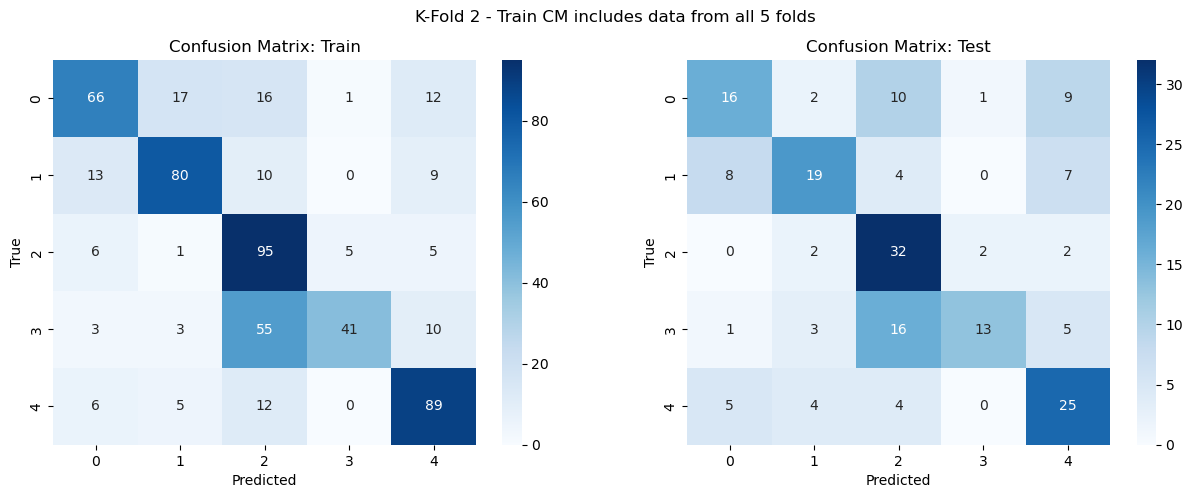

Diese Tatsachen deuten insgesamt auf drei Sachen hin:

1. Das Modell kann tatsächlich sehr wohl vom unlucky/lucky train test split Problem betroffen sein, da die Schwankungen der Genauigkeit >10% betragen. 
2. Das Modell ist trotz Regularisierung und Datenaugmentierung von Overfitting betroffen.
3. Die zwei Klassen, die vor allem vom CNN verwechselt werden, der Dingo und der Dhole, sehr ähnlich sind. Da die Verwechslungsgefahr auch beim Menschen sehr hoch sein kann, deutet das nicht auf ein inhärentes Problem des Designs des CNNs hin. 

## Transfer Learning mit neuen Hunderassen
Übertragen wir nun dieses Modell auf fünf neue Hunderassen: Samoyed, Chow, Keeshond, Brabancon Griffon, Cardigan. Diese Rassen wurden basierend auf zwei Gründen gewählt: zum einen die Accuracy des Modells der Datensatzautoren und zum anderen wurden die Rassen gewählt, die am meisten sichtbare Unterschiede zu den ersten fünf Rassen hatten. So wurden bspw. der Toy Poodle und der Miniature Poodle nicht gewählt, weil unser erstes Modell unter anderem auch auf Bildern des Standard Poodle trainiert wurde. 

In [ ]:
from helpers.dataloader import load_dataset
from numpy.random import seed
import tensorflow as tf

# Setting random seeds
seed(0)
tf.random.set_seed(0)

# Load Training and Testing data for Transfer Learning
transfer_x_train, transfer_y_train = load_dataset("./dataset/Transfer-Train/Images")
transfer_x_test, transfer_y_test = load_dataset("./dataset/Transfer-Test/Images")

Nun können wir ein bereits trainiertes Modell für das Training mit neuen Daten nutzen. Dieser Prozess heißt Transfer Learning, weil die Gewichte eines Modells, das bereits auf ähnlichen Daten trainiert wurde als Basis genommen wird, um Daten einer anderen Art zu klassifizieren. Das ist vor allem vorteilhaft, wenn das Training sehr aufwendig ist, also viele Ressourcen (Zeit und Energie) benötigen. So kann man potentiell Ressourcen schonen und schneller bzw. effizienter bei einem zufriedenstellenden Resultat ankommen.

In [ ]:
from helpers.train import train_cnn

# Transfer learning
_ = train_cnn(
    x_train=transfer_x_train,
    y_train=transfer_y_train,
    x_test=transfer_x_test,
    y_test=transfer_y_test,
    epochs=20,
    batch_size=8,
    lr=3e-4,
    regularization=1e-3,
    sgd=False,
    loadpath="./results/kfolds-2/kfold-2.keras",
    savepath="./results/kfolds-2/kfold-2-transfer.keras",
)

Das Transfer Learning ist also offensichtlich gut gelungen: das Modell erzielt nach derselben Trainingszeit wie das Basismodell bessere Resultate: 73.3929% Genauigkeit auf den Trainingsdaten und 60.5263% bei den Testdaten. Hier noch zusätzlich die Konfusionsmatrix:

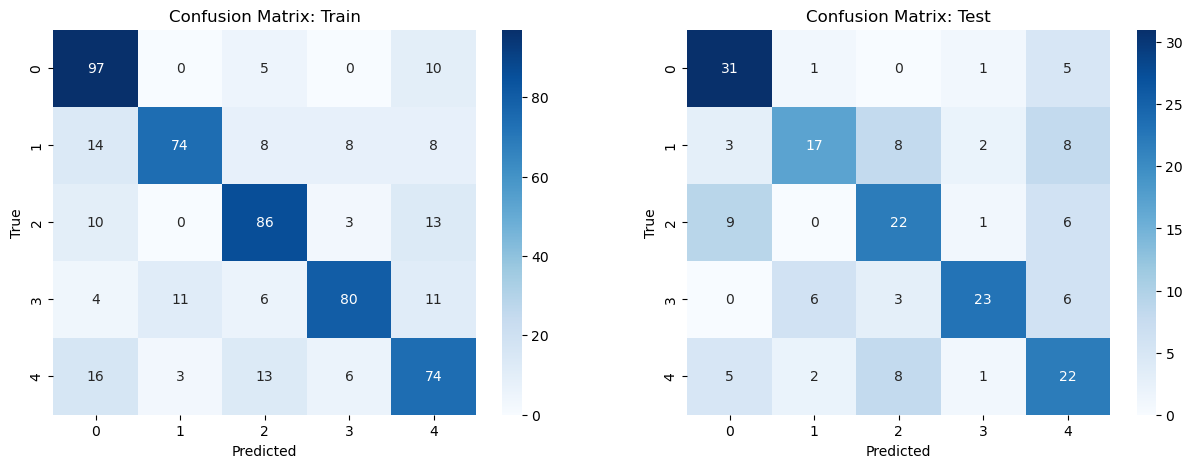

Zum Vergleich kann man noch das Basismodell für 20 weitere Epochen trainieren, um dessen Performance dann mit dem Transfer Learning Modell zu vergleichen:

In [ ]:
from helpers.train import train_cnn

# Longer training of the basis model
_ = train_cnn(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=20,
    batch_size=8,
    lr=3e-4,
    regularization=1e-3,
    sgd=False,
    loadpath="./results/kfolds-2/kfold-2.keras",
    savepath="./results/kfolds-2/kfold-2-longer-training.keras",
)

Interessanterweise ist die Genauigkeit sowohl des Transfer Learning Modells als auch des länger trainierten Basismodells ziemlich ähnlich:

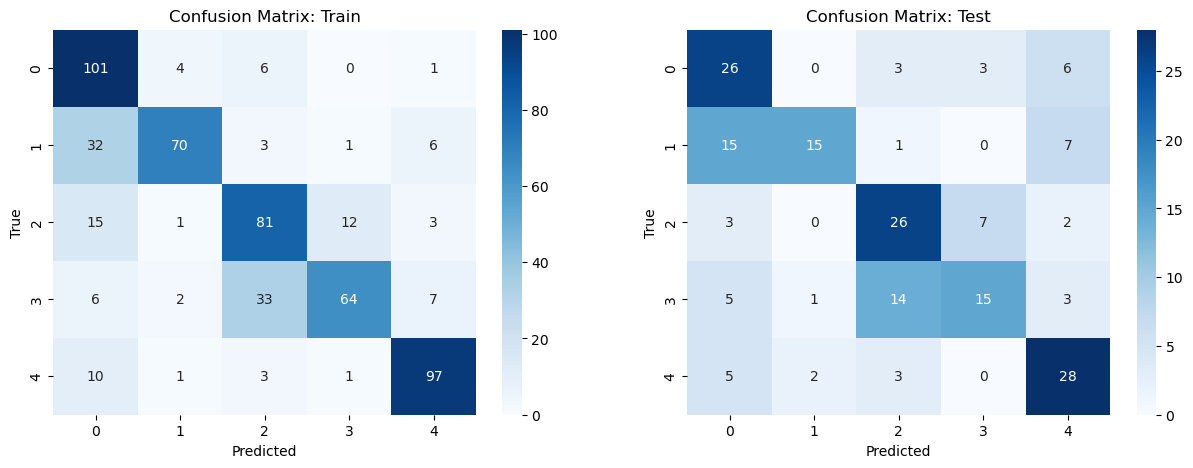

1. Basismodell
    - 20 Epochen mit dem Ausschnitt des Datensatzes des 2. K-Folds (80% des ersten Datensatzes)
    - 66.2500% (Train)
    - 55.2632% (Test)
2. Transfer Learning
    - 20 Epochen mit den Trainingsdaten des 2. K-Folds des ersten Datensatzes und 20 mit dem zweiten Datensatz
    - 73.3929% (Train)
    - 60.5263% (Test)
3. Verlängertes Training (s. Abbildung)
    - 20 Epochen mit den Trainingsdaten des 2. K-Folds des ersten Datensatzes und 20 Epochen mit dem gesamten ersten Datensatz
    - 73.7500% (Train)
    - 57.8947% (Test)

Interessant ist dieses Resultat deswegen, weil das Transfer Learning Modell genauso gut klassifiziert wie das genauso lange trainierte Basismodell (<3% Genauigkeitsunterschied bei Testdaten ist vernachlässigbar).\
Das heißt, dass beide Modelle gleich lang trainiert wurden - 40 Epochen lang. Das Transfer Learning Modell hat aber 20 von 40 Epochen mit Daten trainiert, die jedoch für das Modell nicht unmittelbar wichtig waren. Das länger trainierte Basismodell hat aber alle 40 Epochen ausschließlich mit den für das Modell relevanten Daten trainiert. Dass dadurch keine bemerkenswerten Performanceunterschiede entstanden sind, ist daher auffällig.

Eine mögliche Begründung ist natürlich, dass durch das Transfer Learning gewisse vorteilhafte initiale Werte gesetzt wurden, sodass die notwendige Trainingszeit reduziert wurde.\
Eine weitere Erklärung ist aber jedoch auch die Wahl der Hunderassen. Die Rassen des ersten Datensatzes wurden anhand des Performance des Modells der Datensatzautoren gewählt - der Dingo und der Dhole wurden dabei ordentlich von ihrem Modell klassifiziert, sehen aber ziemlich ähnlich aus. Die gute Klassifikation könnte dabei darauf zurückgeführt werden, dass man diese zwei Hunderassen aber trotzdem ziemlich gut von anderen Rassen unterscheiden kann - dabei ist es dann von keiner allzu hohen Bedeutung, wenn das Modell diese zwei Rassen vertauscht (die Genauigkeit des Modells nach Rasse schwankt zwischen 3% - 58%).\
Die Wahl des Rassen für das Transfer Learning verlief aber anders: es wurden zwar die Rassen gewählt, die ziemlich gut erkannt wurden (es wurde von oben nach unten bei der Klassifikationsgenauigkeit vorgegangen), aber gewisse Rassen wurden dabei übersprungen, die zu ähnlich zu den Rassen des ersten Datensatzes oder zu den neu gewählten Rassen waren.
